## Network Analysis - A Song of Ice and Fire

A Song of Ice and Fire is a popular book series by George R.R. Martin. So far he has published 5 books in this series. In this notebook we are going to analyse the co-occurrence network of the characters throughout these books. The dataset we use here is created by Andrew J. Beveridge and Jie Shan. The dataset is publicly available [here](https://github.com/mathbeveridge/asoiaf). In this dataset, two characters are considered to co-occur if their names appear in the vicinity of 15 words from one another in the books. The number of these co-occurences between two characters in a book is the weight of the edge that connects the two characters. Although it is not a perfect method, it can clearly show some of the important relationships between characters.  
Credits:  
    Mridul Seth's notebook : https://github.com/MridulS/pydata-networkx/blob/master/introduction-and-game-of-thrones-instructor.ipynb

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import Counter
from wordcloud import WordCloud

#### Loading the dataset
The dataset is 5 CSV files containing co-occurence data for each book. 

In [8]:
books = [pd.read_csv(i) for i in glob.glob('data/*.csv')]

In [9]:
books[0].head()

,Source,Target,Type,weight,book
0,Addam-Marbrand,Jaime-Lannister,Undirected,3,1
1,Addam-Marbrand,Tywin-Lannister,Undirected,6,1
2,Aegon-I-Targaryen,Daenerys-Targaryen,Undirected,5,1
3,Aegon-I-Targaryen,Eddard-Stark,Undirected,4,1
4,Aemon-Targaryen-(Maester-Aemon),Alliser-Thorne,Undirected,4,1


If we wanted the edges of the co-occurences to be directed, we can use the order of the names appear in the text to define source and target. But for this analysis we will use undirected graphs for all books.

Before we get into network stuff, let's check some basic details

#### Basic details about the data

In [20]:
chracter_counts = []
for i,book in enumerate(books,1):
    chracter_counts.append(Counter(book['Source']))
    chracter_counts[-1].update(book['Target'])
    print('Book {} data has {} characters'.format(i,len(chracter_counts[-1])))
    

Book 1 data has 187 characters
Book 2 data has 259 characters
Book 3 data has 303 characters
Book 4 data has 274 characters
Book 5 data has 317 characters


In [21]:
total_characters = Counter()
for i in chracter_counts: total_characters.update(i)
print('There are {} characters in the dataset'.format(len(total_characters)))

There are 796 characters in the dataset


Now we can see who are the most common characters in each book data and in total

#### Most common characters

In [41]:
for i,j in enumerate(chracter_counts,1): print('Book {} : {}'.format(i,', '.join([n for n,c in j.most_common(5)])))
print('Total  : {}'.format(', '.join([n for n,c in total_characters.most_common(5)])))

Book 1 : Eddard-Stark, Robert-Baratheon, Tyrion-Lannister, Catelyn-Stark, Jon-Snow
Book 2 : Tyrion-Lannister, Joffrey-Baratheon, Cersei-Lannister, Arya-Stark, Stannis-Baratheon
Book 3 : Tyrion-Lannister, Jon-Snow, Joffrey-Baratheon, Robb-Stark, Sansa-Stark
Book 4 : Jaime-Lannister, Cersei-Lannister, Brienne-of-Tarth, Tyrion-Lannister, Margaery-Tyrell
Book 5 : Jon-Snow, Daenerys-Targaryen, Stannis-Baratheon, Theon-Greyjoy, Tyrion-Lannister
Total  : Tyrion-Lannister, Cersei-Lannister, Jon-Snow, Jaime-Lannister, Stannis-Baratheon


Not clear enough! How about some **worldclouds!**

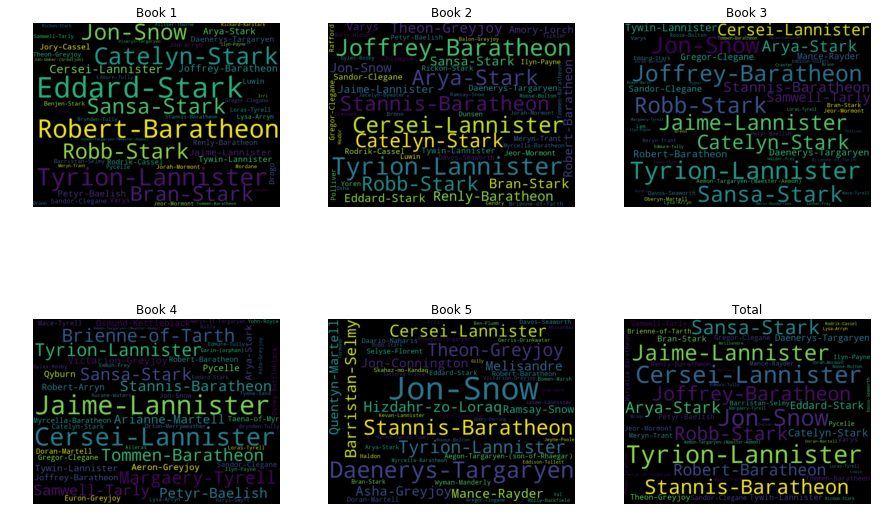

In [58]:
dictx = {'Book {}'.format(i):j for i,j in enumerate(chracter_counts,1)}
dictx['Total'] = total_characters

_, axarr = plt.subplots(2,3,figsize=(15, 10))
axa = iter(axarr.reshape(-1))
for key,val in dictx.items():
    cax = next(axa)
    cax.axis('off')
    cax.imshow(WordCloud(width=800, height=600, margin=0,max_words=50).generate_from_frequencies(val), \
                  interpolation='bilinear')
    cax.margins(x=0, y=0)
    cax.set_title(key)

We can see some characters becomes dominant while some disappears in the book series.   
Now we create a graph for each book using dataframes.

### Networks

In [63]:
graphs = []
for book in books:
    graphs.append(nx.Graph())
    for item in book.itertuples(): graphs[-1].add_edge(item.Source, item.Target, weight=item.weight) 

We can check how the data is represented in the network

In [66]:
list(graphs[0].edges(data=True))[0]

('Addam-Marbrand', 'Jaime-Lannister', {'weight': 3})

How to find the most important character? There are few methods. Let's have a look

#### Degree of Centrality

Degree of centrality of a node is equal to number of neighbors it has or in other words number of nodes it is directly connected to

In [67]:
degree_of_centralities = [nx.degree_centrality(i) for i in graphs]

In [100]:
sorted(degree_of_centralities[0].items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.3548387096774194),
 ('Robert-Baratheon', 0.2688172043010753),
 ('Tyrion-Lannister', 0.24731182795698928),
 ('Catelyn-Stark', 0.23118279569892475),
 ('Jon-Snow', 0.19892473118279572),
 ('Robb-Stark', 0.18817204301075272),
 ('Sansa-Stark', 0.18817204301075272),
 ('Bran-Stark', 0.17204301075268819),
 ('Cersei-Lannister', 0.16129032258064518),
 ('Joffrey-Baratheon', 0.16129032258064518)]

In [80]:
dfs = [pd.DataFrame(sorted(i.items(), key=lambda x:x[1], reverse=True)[0:10],columns=['name','val']) for i in degree_of_centralities]

In [81]:
dfs[0]

,name,val
0,Eddard-Stark,0.354839
1,Robert-Baratheon,0.268817
2,Tyrion-Lannister,0.247312
3,Catelyn-Stark,0.231183
4,Jon-Snow,0.198925
5,Robb-Stark,0.188172
6,Sansa-Stark,0.188172
7,Bran-Stark,0.172043
8,Cersei-Lannister,0.161290
9,Joffrey-Baratheon,0.161290


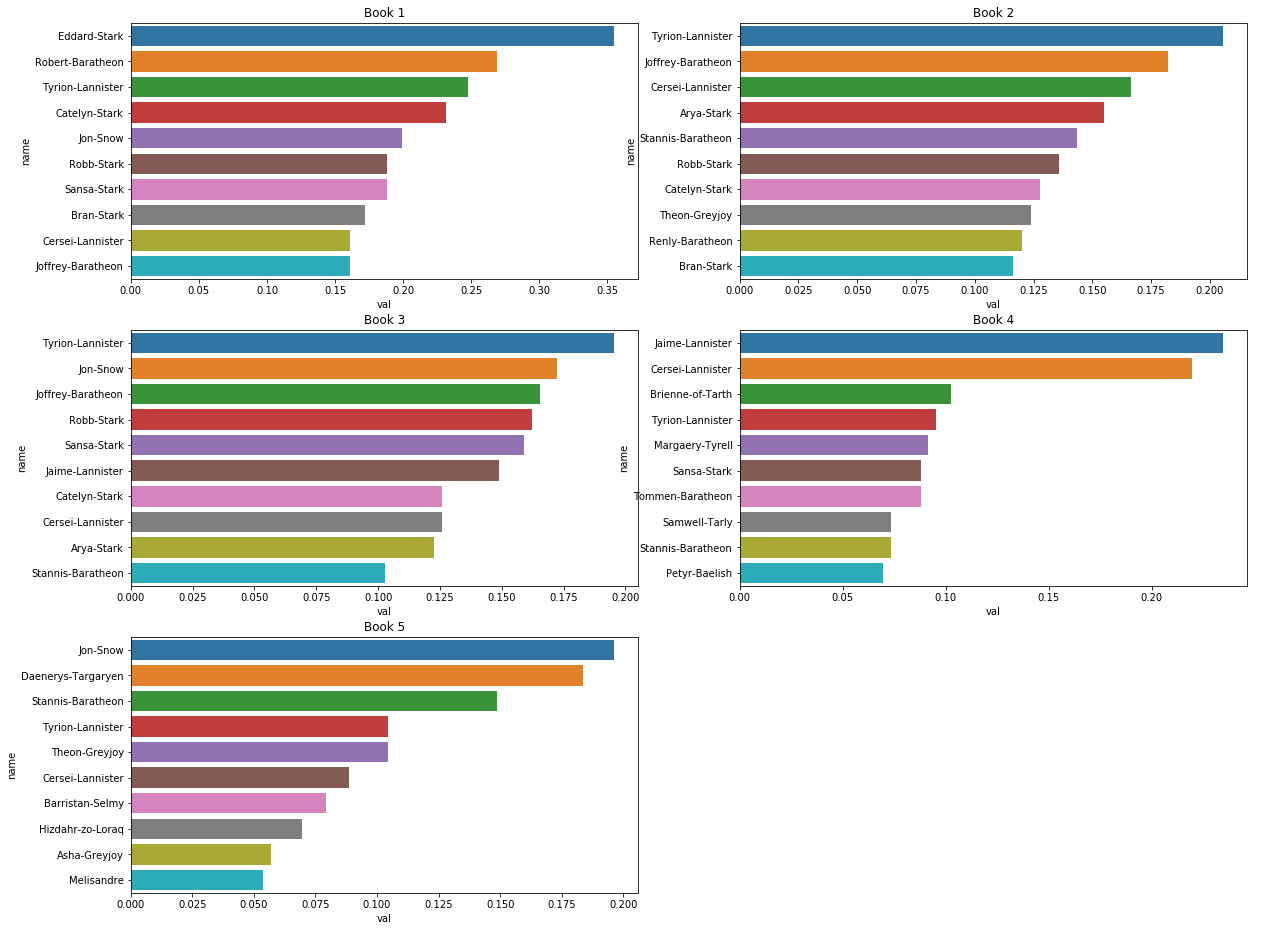

In [98]:
_, axarr = plt.subplots(3,2,figsize=(20, 16))
axa = axarr.reshape(-1)
for i in range(len(axa)):
    cax = axa[i]
    if(i<len(dfs)):
        sns.barplot(x='val',y='name', data=dfs[i], ax=cax)
        cax.set_title('Book {}'.format(i+1))
    else:
        cax.axis('off')

#### Betweenness Centrality

For a node, betweenness centrality is equal to number shortest paths that pass through it

In [102]:
betweenness_centralities = [nx.betweenness_centrality(i) for i in graphs]
sorted(betweenness_centralities[0].items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.2696038913836117),
 ('Robert-Baratheon', 0.21403028397371796),
 ('Tyrion-Lannister', 0.1902124972697492),
 ('Jon-Snow', 0.17158135899829566),
 ('Catelyn-Stark', 0.1513952715347627),
 ('Daenerys-Targaryen', 0.08627015537511595),
 ('Robb-Stark', 0.07298399629664767),
 ('Drogo', 0.06481224290874964),
 ('Bran-Stark', 0.05579958811784442),
 ('Sansa-Stark', 0.03714483664326785)]

By default betweenness centrality function does not use any value for the weight attribute. So we need to add it.

In [103]:
betweenness_centralities_weighted = [nx.betweenness_centrality(i,weight='weight') for i in graphs]
sorted(betweenness_centralities_weighted[0].items(), key=lambda x:x[1], reverse=True)[0:10]

[('Robert-Baratheon', 0.23341885664466297),
 ('Eddard-Stark', 0.18703429235687297),
 ('Tyrion-Lannister', 0.15311225972516293),
 ('Robb-Stark', 0.1024018949825402),
 ('Catelyn-Stark', 0.10169012330302643),
 ('Jon-Snow', 0.09027684366394043),
 ('Jaime-Lannister', 0.07745109164464009),
 ('Rodrik-Cassel', 0.07667992877670296),
 ('Drogo', 0.06894355184677767),
 ('Jorah-Mormont', 0.0627085149665795)]

#### Page Rank

PageRank works by counting the number and quality of edges to a node to determine a rough estimate of how important the node is

In [104]:
page_ranks = [nx.pagerank_numpy(i, weight=None) for i in graphs]
sorted(page_ranks[0].items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.045520792228306635),
 ('Tyrion-Lannister', 0.03301362462493266),
 ('Catelyn-Stark', 0.03019310528663189),
 ('Robert-Baratheon', 0.029834742227736685),
 ('Jon-Snow', 0.02683449952206629),
 ('Robb-Stark', 0.02156294129724752),
 ('Sansa-Stark', 0.020008034042864626),
 ('Bran-Stark', 0.019945786786238335),
 ('Jaime-Lannister', 0.017507847202846868),
 ('Cersei-Lannister', 0.017082604584758066)]

In [105]:
page_ranks_weighted = [nx.pagerank_numpy(i, weight='weight') for i in graphs]
sorted(page_ranks_weighted[0].items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.07239401100498274),
 ('Robert-Baratheon', 0.048517275705099575),
 ('Jon-Snow', 0.04770689062474904),
 ('Tyrion-Lannister', 0.04367437892706297),
 ('Catelyn-Stark', 0.03466703470130745),
 ('Bran-Stark', 0.02977420053980021),
 ('Robb-Stark', 0.029216183645196868),
 ('Daenerys-Targaryen', 0.027089622513021112),
 ('Sansa-Stark', 0.026961778915683174),
 ('Cersei-Lannister', 0.02163167939741901)]

In each method the value for a name and order of names are different. But it seems like most of the top charactes stays in the top, just in diffrent positions. So how similar are the results of these methods

In [106]:
cor = pd.DataFrame.from_records([degree_of_centralities[0], betweenness_centralities_weighted[0], page_ranks_weighted[0]],\
                               index=['deg_cen','bet_cen','pag_ran'])

In [107]:
cor.T.corr()

,deg_cen,bet_cen,pag_ran
deg_cen,1.000000,0.871385,0.949307
bet_cen,0.871385,1.000000,0.870214
pag_ran,0.949307,0.870214,1.000000


Let's see how degree of centrality for the top characters changes throughout the books

In [109]:
evol_df = pd.DataFrame.from_records(degree_of_centralities, index=['Book {}'.format(i) for i in range(1,6)]).fillna(0)

In [120]:
set_of_char = set()
for book in evol_df.index: set_of_char |= set(list(evol_df.T[book].sort_values(ascending=False)[0:5].index))
set_of_char

{'Arya-Stark',
 'Brienne-of-Tarth',
 'Catelyn-Stark',
 'Cersei-Lannister',
 'Daenerys-Targaryen',
 'Eddard-Stark',
 'Jaime-Lannister',
 'Joffrey-Baratheon',
 'Jon-Snow',
 'Margaery-Tyrell',
 'Robb-Stark',
 'Robert-Baratheon',
 'Sansa-Stark',
 'Stannis-Baratheon',
 'Theon-Greyjoy',
 'Tyrion-Lannister'}

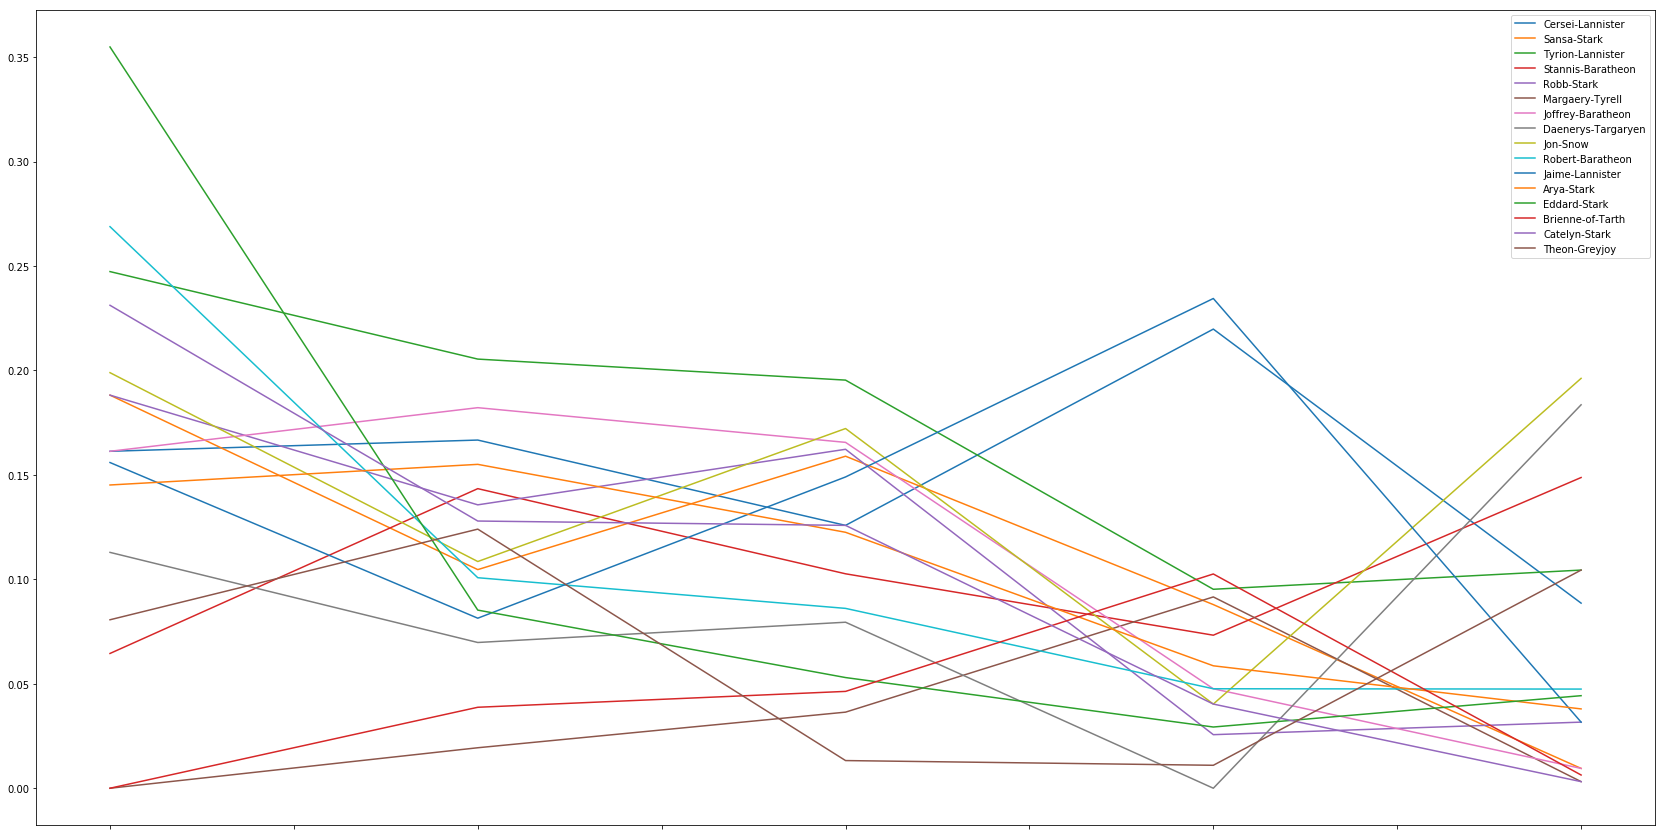

In [122]:
_ = evol_df[list(set_of_char)].plot(figsize=(29,15))